In [1]:
pwd()

"/home/xlx0727/Scripts/Statistic/qgplsim"

In [193]:
200^(-1/9)

0.5550473077848115

# DGP

In [8]:
using DelimitedFiles, Distributions

In [9]:
student_t = StudentizedRange(2, 4)

StudentizedRange{Float64}(ν=2.0, k=4.0)

In [10]:
ϵt = rand(student_t, 10000)

10000-element Vector{Float64}:
  3.597979789938165
  3.54969319195895
  1.5564408719413056
  2.9871760537417775
  1.5702612075927673
  1.4713240568694907
  1.531758424185755
  0.5374031508111166
  4.856515132555273
  1.1463886382318578
  3.820407011188215
  4.191334478526554
  0.8295125083789314
  ⋮
  2.7216024303752797
  1.7094553365533702
  4.0258985664497144
  1.6588917004283081
  0.47473328443318397
  2.6007504715895897
  2.036553256417447
  1.461644737711964
  5.64813107594452
  0.5850625578635363
  1.5203503932945144
 10.190779151110418

In [11]:
filename = "studentized.txt"
open(filename, "a") do io
    writedlm(io, ϵt)
end

In [14]:
et = readdlm(filename, Float64)
size(et)

(12000, 1)

In [15]:
e = rand(et, n)

6000-element Vector{Float64}:
  4.575047142797644
  3.6848878453291003
  1.4426902734647504
  4.209871105904695
  0.5774682553585652
  1.47508605912979
  1.4492245006190492
  4.695030199548825
  3.762500417028904
  4.012531803565649
  0.9054745045662814
  2.154154289028013
  4.284527601874077
  ⋮
 10.812945017834114
  1.6525078329575664
  3.2635142676477127
  1.2218268950158504
  0.4048278192420169
  5.177750852382616
  5.9665998714651405
  1.2367083901430007
  3.3237275896104896
  2.108477846580277
  2.5742790140207097
  1.7305087729367528

# QGPLSIM fitting

In [40]:
# run this ceil if source codes was edited
include("DGP.ji")
# include("qgplsim.ji")
include("MonteCarloSIM.ji")
using Statistics, LinearAlgebra, Clustering
using LaTeXStrings, Plots

import Base.Threads.@threads

α = [-0.5, 1.0, -2.0] # single index for x, α[1] = c0
θ = [0.0, 2.0, 1.0]  # linear for x, <α, θ> = 0 for identification, θ[1] = c1 := 0
γ = [0.5, 1.0]  * 2.0 # single index for z
# β = [-1.0, 0.5] # linear for z
β = [0.5, -0.5] * 1.0

# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n_ = 250
n0 = 500
n1 = 750
n2 = 1000
n3 = 1500
n4 = 2000
n5 = 3000
n6 = 4000
n7 = 6000
n8 = 8000
n9 = 12000
n = n4

fx = 2 # y = f(x), fx for different f(x)     
                # fx = 1, y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ
                # fx = 2, y = X*θ + Z*β + log.(1 .+ exp.(X*α + Z*γ .- 1)) + 0.2ϵ

ifz = true # if false, Z = 0, i.e. no category varible
dist = 1 # 0 for gauss, 1 for t
X, Z, y = dgp(n, γ, θ, α, β, fx, dist,  ifz)
# p = length(α)
# q = length(γ)
τ = 0.5
intercept = 0
# Estimation 

model1 = qgplsim.model(X, Z, y, τ, intercept)
alpha_type = 1

# different weight of sum on alpha 
# 0 for true alpha, using α in DGP
# 1 for estimated  ̂α

@time alpha1, gamma, theta, beta, squ = qgplsim.estimator(model1, alpha_type)

println("Estimation of index coefs: ")
println("̂α => ", alpha1)
println("̂γ => ", gamma)

println("Estimation of linear coefs: ")
println("̂θ => ", theta)
println("̂β => ", beta)

println("square of integral: ", squ)

# theta * alpha

 21.697600 seconds (28.46 M allocations: 17.026 GiB, 10.96% gc time, 21.88% compilation time)
Estimation of index coefs: 
̂α => [0.44554037103246186, -0.895261848723744]
̂γ => [0.5761919194906646, 1.0172019809782835]
Estimation of linear coefs: 
̂θ => [2.0112637230320827 1.0009352980709434]
̂β => [1.2720661003571478, 0.06760801081197693]
square of integral: 5.840947475411135


# Paths of $g(x \alpha + z \gamma)$ and $\nabla g$

$\alpha = \hat{\alpha}$,
$z \in S_z$

width = 0.37372684104653553
dy = 1.2690096736133354
dx = 4.640368824318612


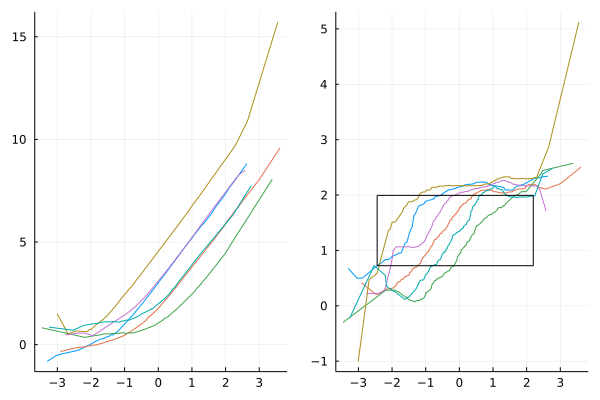

In [43]:
g = zeros(n)
dg = zeros(n)
yz = y - X * transpose(theta)


X = [ones(n, intercept) X]
v = X * alpha1 
categ, index = model1.categ, model1.index
z = collect(index)
ncateg = index.count
width = zeros(ncateg)
v0 = -1e6
v1 = 1e6

for k in 1:ncateg
    vk = v[z[k][2]]
    h = (length(vk))^(-0.17) * var(vk)
    width[k] = h

    dgk(u) = qgplsim.Gz(u, vk, yz[z[k][2]], 1, τ)
    gk(u) = qgplsim.Gz(u, vk, yz[z[k][2]], 0, τ)

    dg[z[k][2]] = dgk(vk)
    g[z[k][2]] = gk(vk)

    vkmin = minimum(vk) + h # + h
    vkmax = maximum(vk) - h# - h

    if  vkmin > v0
        v0 = vkmin
    end
    if  vkmax < v1
        v1 = vkmax
    end  
end

# g, dg = qgplsim.G(v, Z, yz, τ, -0.4) # g: g(v), dg: g'(v)

println("width = ", mean(width))
# v0, v1 = v0 + h, v1 - h
# v0, v1

v_ = v[v .> v1]
_v = v[v .< v0]

v_ = minimum(v_)
_v = maximum(_v)
# _v, v_

C0 = zeros(ncateg)
C1 = zeros(ncateg)
dgf(vv, k) = qgplsim.Gz(vv, v[z[k][2]], yz[z[k][2]], 1, τ)


p1 = plot()
p2 = plot()
for m in 1:ncateg
    C0[m] = dgf(_v, m)[1]
    C1[m] = dgf(v_, m)[1]

    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]
    plot!(p1, sorted_vm, sorted_gm, label = false ) # L"g_{%$m} (v)")
    plot!(p2, sorted_vm, sorted_dgm, label = false ) # L"\nabla g_{%$m} (v)")

end

c0 = maximum(C0)
c1 = minimum(C1)
println("dy = ", c1 - c0)
println("dx = ", v1 - v0)

plot!(p2, [v0, v0], [c0, c1], color = "black", label = false)
plot!(p2, [v1, v1], [c0, c1], color = "black", label = false)
plot!(p2, [v0, v1], [c0, c0], color = "black", label = false)
plot!(p2, [v0, v1], [c1, c1], color = "black", label = false)


plot(p1, p2, layout = (1,2))

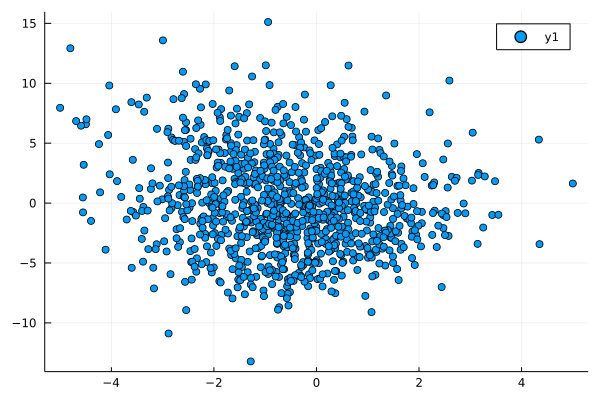

In [98]:
scatter(X[:,2], y)

# Monte Carlo Simulation

In [145]:
Threads.nthreads()

2

In [7]:
include("MonteCarloSIM.ji")

α = [-1.0, 1.0, -2.0] # single index for x
θ = [0.0, 2.0, 1.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 1.0] # single index for z
# β = [-1.0, 0.5] # linear for z
β = [0.5, -0.5] 

τ = 0.5
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n = n0
fx = 1
dist = 1 # 1 for t
intercept = 0
rep = 200 # MC rept. times

200

## Different Quant

In [225]:
@time Alpha, Gamma, Theta, Beta, Squ = MonteCarlo(n, γ, θ, α, β, 0.1, fx, dist, intercept, rep)

mb_ = mean(Beta, dims = 1)

mt_ = mean(Theta, dims = 1)

ma_ = mean(Alpha, dims = 1)

mg_ = mean(Gamma, dims = 1) 

265.834890 seconds (1.38 G allocations: 798.481 GiB, 33.33% gc time, 0.66% compilation time)


1×2 Matrix{Float64}:
 0.307931  0.594073

In [188]:
@time Alpha, Gamma, Theta, Beta, Squ = MonteCarlo(n, γ, θ, α, β, 0.25, fx, dist, intercept, rep)

mb0 = mean(Beta, dims = 1)

mt0 = mean(Theta, dims = 1)

ma0 = mean(Alpha, dims = 1)

mg0 = mean(Gamma, dims = 1) 

 42.149247 seconds (366.49 M allocations: 143.178 GiB, 22.74% gc time)


1×2 Matrix{Float64}:
 0.360557  0.734407

In [190]:
@time Alpha, Gamma, Theta, Beta, Squ = MonteCarlo(n, γ, θ, α, β, 0.75, fx, dist, intercept, rep)

mb2 = mean(Beta, dims = 1)

mt2 = mean(Theta, dims = 1)

ma2 = mean(Alpha, dims = 1)

mg2 = mean(Gamma, dims = 1) 

 41.438440 seconds (355.91 M allocations: 137.162 GiB, 28.01% gc time)


1×2 Matrix{Float64}:
 0.326819  0.722537

In [191]:
@time Alpha, Gamma, Theta, Beta, Squ = MonteCarlo(n, γ, θ, α, β, 0.9, fx, dist, intercept, rep)

mb3 = mean(Beta, dims = 1)

mt3 = mean(Theta, dims = 1)

ma3 = mean(Alpha, dims = 1)

mg3 = mean(Gamma, dims = 1) 

 44.918757 seconds (403.71 M allocations: 162.037 GiB, 28.08% gc time)


1×2 Matrix{Float64}:
 0.316076  0.676516

## $\tau = 0.5$ 

In [8]:
@time Alpha, Gamma, Theta, Beta, Squ = MonteCarlo(n, γ, θ, α, β, 0.5, fx, dist, intercept, rep)

mb1 = mean(Beta, dims = 1)

mt1 = mean(Theta, dims = 1)

ma1 = mean(Alpha, dims = 1)

mg1 = mean(Gamma, dims = 1) 

308.274650 seconds (689.12 M allocations: 256.777 GiB, 27.72% gc time, 1.76% compilation time)


1×2 Matrix{Float64}:
 0.351525  0.735028

In [4]:
mg1

1×2 Matrix{Float64}:
 0.341487  0.728873

In [5]:
mg1  * 1/ma1[1]

1×2 Matrix{Float64}:
 0.764948  1.63271

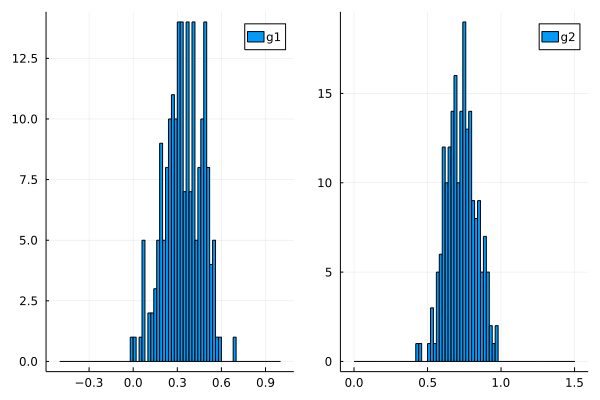

In [6]:
p1 = histogram(Gamma[:,1], bins = -0.5:0.02:1, label = "g1")
p2 = histogram(Gamma[:,2], bins = 0:0.02:1.5, label = "g2")
plot(p1, p2, layout = (1, 2))

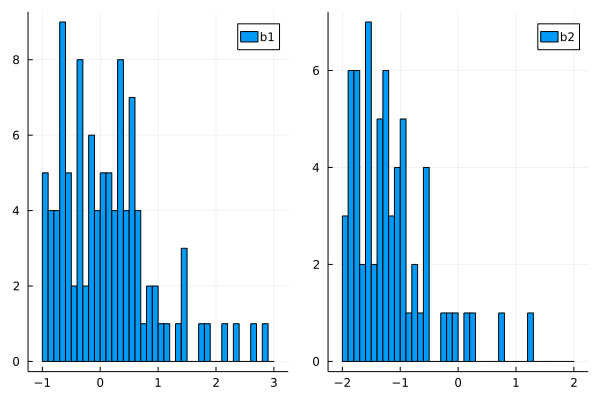

In [9]:

p1 = histogram(Beta[:,1], bins = -1:0.1:3, label = "b1")
p2 = histogram(Beta[:,2], bins = -2:0.1:2, label = "b2")
plot(p1, p2, layout = (1, 2))

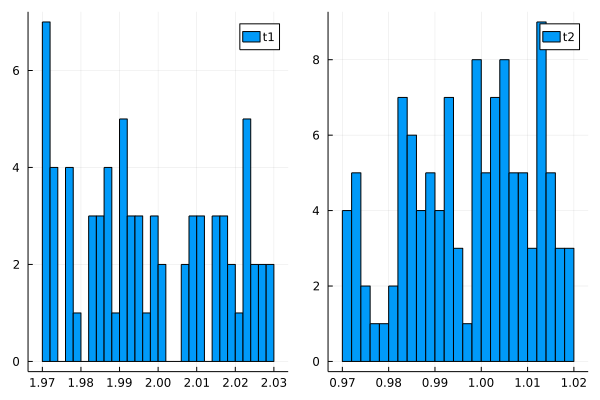

In [14]:
p1 = histogram(Theta[:,1], bins = 1.97:0.002:2.03, label = "t1")
p2 = histogram(Theta[:,2], bins = 0.97:0.002:1.02, label = "t2")
plot(p1, p2, layout = (1, 2))

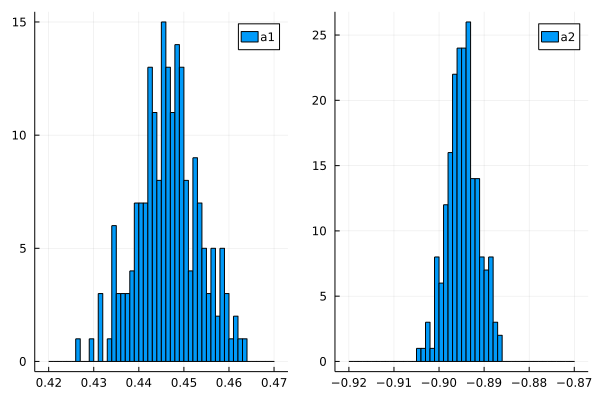

In [16]:
p1 = histogram(Alpha[:,1], bins = 0.42:0.001:0.47, label = "a1")
p2 = histogram(Alpha[:,2], bins = -0.92:0.001:-0.87, label = "a2")
plot(p1, p2, layout = (1, 2))

In [79]:
filename = "./simulations/records/250 f2 d1 1.0 0.5.mat"

"./simulations/records/250 f2 d1 1.0 0.5.mat"

In [80]:
using MAT, Statistics

In [81]:
d = matread(filename)
g = d["Gamma"]
a = d["Alpha"]
ma = mean(a, dims = 1)

1×2 Matrix{Float64}:
 0.428657  0.606587

In [82]:
mg = mean(g, dims = 1)

1×2 Matrix{Float64}:
 0.275254  0.126393

In [83]:
mg * 1.6

1×2 Matrix{Float64}:
 0.440406  0.202228

# Postprocess

In [9]:
using MAT
filename = "a=[-1,1,-2]/records/"

"a=[-1,1,-2]/records/"